# Classifying Food Reviews

Data __Amazon Food Reviews__
* We are using a transformed version of this 500k dataset
* Reference: https://snap.stanford.edu/data/web-FineFoods.html

In [ ]:
!ls

In [3]:
# Run this if you do not already have Reviews.csv downloaded
!wget "https://www.dropbox.com/s/fxtgg2v2r8lua01/Reviews.csv?dl=0" -O Reviews.csv  

Will not apply HSTS. The HSTS database must be a regular and non-world-writable file.
ERROR: could not open HSTS store at '/home/yashroff/.wget-hsts'. HSTS will be disabled.
--2021-11-16 00:16:16--  https://www.dropbox.com/s/fxtgg2v2r8lua01/Reviews.csv?dl=0
Resolving proxy-chain.intel.com (proxy-chain.intel.com)... 10.1.201.150
Connecting to proxy-chain.intel.com (proxy-chain.intel.com)|10.1.201.150|:912... connected.
Proxy request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/fxtgg2v2r8lua01/Reviews.csv [following]
--2021-11-16 00:16:17--  https://www.dropbox.com/s/raw/fxtgg2v2r8lua01/Reviews.csv
Reusing existing connection to www.dropbox.com:443.
Proxy request sent, awaiting response... 302 Found
Location: https://uc0f95489cbd73efa2abff4ddc5f.dl.dropboxusercontent.com/cd/0/inline/BaHNhfQr2kULNv1jQ0jrb8tuEhCOfV4ay6bZkYpdY675l4ilunYru_nu4Typz57UT53WWkp0ukLgZHshpKpxp9slIMw3vPaFJHGZi4_9ChV2A-Q3BEV8LQcQQ6ML5PawYqpeMa_nFBfNNS9jq9YtNvB0/file# [following]
--2021-11-16 00:

In [1]:
!ls

01_NLP_basics.ipynb	      07a_disaster_detection_tfidf.py
02_OHE.ipynb		      07a_predict_disaster_tfidf.py
03_SpaCy.ipynb		      07b_disaster_detection_tfidf.py
03b_SpaCy_exercises.ipynb     08_deploy_model.py
03c_Spacy_Pipelines.ipynb     Reviews.csv
03d_SpaCy_Food_Reviews.ipynb  score.png
05_word2vec.ipynb	      score_boolean.png
06_simpleRNN.ipynb


In [5]:
!python -m spacy download en_core_web_sm

2021-11-16 00:17:35.798122: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2021-11-16 00:17:35.798197: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
     |████████████████████████████████| 13.9 MB 20.2 MB/s 
You should consider upgrading via the '/home/yashroff/.cache/pypoetry/virtualenvs/ds-kO09CnjC-py3.8/bin/python -m pip install --upgrade pip' command.
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


In [2]:
import pandas as pd
import numpy as np
import spacy
from spacy import displacy
from spacy.util import minibatch, compounding

import matplotlib.pyplot as plt
%matplotlib inline

2021-11-16 01:06:36.890794: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2021-11-16 01:06:36.890844: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [3]:
food_reviews_df=pd.read_csv('Reviews.csv')
food_reviews_df.shape

(568454, 10)

In [4]:
food_reviews_df.head().T

,0,1,2,3,4
Id,1,2,3,4,5
ProductId,B001E4KFG0,B00813GRG4,B000LQOCH0,B000UA0QIQ,B006K2ZZ7K
UserId,A3SGXH7AUHU8GW,A1D87F6ZCVE5NK,ABXLMWJIXXAIN,A395BORC6FGVXV,A1UQRSCLF8GW1T
ProfileName,delmartian,dll pa,"Natalia Corres ""Natalia Corres""",Karl,"Michael D. Bigham ""M. Wassir"""
HelpfulnessNumerator,1,0,1,3,0
HelpfulnessDenominator,1,0,1,3,0
Score,5,1,4,2,5
Time,1303862400,1346976000,1219017600,1307923200,1350777600
Summary,Good Quality Dog Food,Not as Advertised,"""Delight"" says it all",Cough Medicine,Great taffy
Text,I have bought several of the Vitality canned d...,Product arrived labeled as Jumbo Salted Peanut...,This is a confection that has been around a fe...,If you are looking for the secret ingredient i...,Great taffy at a great price. There was a wid...


In [5]:
food_reviews_df = food_reviews_df[['Text', 'Score']].dropna()

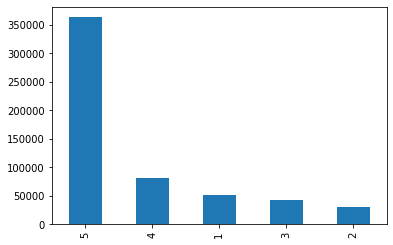

In [6]:
ax=food_reviews_df.Score.value_counts().plot(kind='bar')
fig = ax.get_figure()
fig.savefig("score.png");

In [7]:
food_reviews_df.loc[food_reviews_df.Score <= 3, "Score"] = 0
food_reviews_df.loc[food_reviews_df.Score >= 4, "Score"] = 1

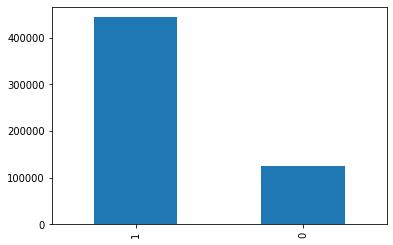

In [8]:
ax=food_reviews_df.Score.value_counts().plot(kind='bar')
fig = ax.get_figure()
fig.savefig("score_boolean.png");

In [9]:
food_reviews_df.head()

,Text,Score
0,I have bought several of the Vitality canned d...,1
1,Product arrived labeled as Jumbo Salted Peanut...,0
2,This is a confection that has been around a fe...,1
3,If you are looking for the secret ingredient i...,0
4,Great taffy at a great price. There was a wid...,1


In [10]:
train_pos_df=food_reviews_df[food_reviews_df.Score==1][:5000]
train_neg_df=food_reviews_df[food_reviews_df.Score==0][:5000]

In [11]:
train_df=train_pos_df.append(train_neg_df)
train_df.shape

(10000, 2)

## Pre-Processing
### Tokenization

In [12]:
nlp = spacy.load('en_core_web_sm') # create nlp object for English
sample_review = food_reviews_df.Text[101]
sample_review

"Arrived slightly thawed. My parents wouldn't accept it. However, the company was very helpful and issued a full refund."

In [13]:
parsed_review = nlp(sample_review)
parsed_review

Arrived slightly thawed. My parents wouldn't accept it. However, the company was very helpful and issued a full refund.

## Parts of Speech Tagging

In [14]:
tokenized_text = pd.DataFrame()

for i, token in enumerate(parsed_review):
    tokenized_text.loc[i, 'text'] = token.text
    tokenized_text.loc[i, 'lemma'] = token.lemma_,
    tokenized_text.loc[i, 'pos'] = token.pos_
    tokenized_text.loc[i, 'tag'] = token.tag_
    tokenized_text.loc[i, 'dep'] = token.dep_
    tokenized_text.loc[i, 'shape'] = token.shape_
    tokenized_text.loc[i, 'is_alpha'] = token.is_alpha
    tokenized_text.loc[i, 'is_stop'] = token.is_stop
    tokenized_text.loc[i, 'is_punctuation'] = token.is_punct

tokenized_text[:20]

,text,lemma,pos,tag,dep,shape,is_alpha,is_stop,is_punctuation
0,Arrived,arrive,VERB,VBN,nsubj,Xxxxx,True,False,False
1,slightly,"(slightly,)",ADV,RB,advmod,xxxx,True,False,False
2,thawed,"(thaw,)",VERB,VBN,ROOT,xxxx,True,False,False
3,.,"(.,)",PUNCT,.,punct,.,False,False,True
4,My,"(my,)",PRON,PRP$,poss,Xx,True,True,False
5,parents,"(parent,)",NOUN,NNS,nsubj,xxxx,True,False,False
6,would,"(would,)",AUX,MD,aux,xxxx,True,True,False
7,n't,"(not,)",PART,RB,neg,x'x,False,True,False
8,accept,"(accept,)",VERB,VB,ROOT,xxxx,True,False,False
9,it,"(it,)",PRON,PRP,dobj,xx,True,True,False


## Named Entity Recognition (NER)

| Type        | Description                                          |
| :---------- | :--------------------------------------------------- |
| PERSON      | People, including fictional.                         |
| NORP        | Nationalities or religious or political groups.      |
| FAC         | Buildings, airports, highways, bridges, etc.         |
| ORG         | Companies, agencies, institutions, etc.              |
| GPE         | Countries, cities, states.                           |
| LOC         | Non-GPE locations, mountain ranges, bodies of water. |
| PRODUCT     | Objects, vehicles, foods, etc. (Not services.)       |
| EVENT       | Named hurricanes, battles, wars, sports events, etc. |
| WORK_OF_ART | Titles of books, songs, etc.                         |
| LAW         | Named documents made into laws.                      |
| LANGUAGE    | Any named language.                                  |
| DATE        | Absolute or relative dates or periods.               |
| TIME        | Times smaller than a day.                            |
| PERCENT     | Percentage, including "%".                           |
| MONEY       | Monetary values, including unit.                     |
| QUANTITY    | Measurements, as of weight or distance.              |
| ORDINAL     | "first", "second", etc.                              |
| CARDINAL    | Numerals that do not fall under another type         |


## Dependency parsing

Identifies sentences, assigning a syntactic structure to it (subject-object)

In [15]:
sentence_spans = list(parsed_review.sents)
sentence_spans

[Arrived slightly thawed.,
 My parents wouldn't accept it.,
 However, the company was very helpful and issued a full refund.]

In [16]:
options = {'compact': True, 'bg': 'white','distance': 80,
           'color': 'green', 'font': 'Arial'}
displacy.render(parsed_review, jupyter=True, style='dep', options=options)

## Processing noun chunks 

The dependency parser adds the `token.dep` and `token.head` attributes
Further, it is also responsible for **noun chunks**: detecting sentences and base noun phrases

In [17]:
noun_chunks_df = pd.DataFrame()

for i, chunk in enumerate(parsed_review.noun_chunks):
    noun_chunks_df.loc[i, 'text'] = chunk.text
    noun_chunks_df.loc[i, 'root'] = chunk.root,
    noun_chunks_df.loc[i, 'root.text'] = chunk.root.text,
    noun_chunks_df.loc[i, 'root.dep_'] = chunk.root.dep_
    noun_chunks_df.loc[i, 'root.head.text'] = chunk.root.head.text

noun_chunks_df[:20]

,text,root,root.text,root.dep_,root.head.text
0,My parents,parents,parents,nsubj,accept
1,it,"(it,)","(it,)",dobj,accept
2,the company,"(company,)","(company,)",nsubj,was
3,a full refund,"(refund,)","(refund,)",dobj,issued


## Text Classification

By default, spaCy's text categorizer uses CNN to assign position sensitive vectors to each word in the document. First, prepare the data spaCy expects, in the form of tuples.

In [18]:
train_df['tuples'] = train_df.apply(
    lambda row: (row['Text'],row['Score']), axis=1)
train = train_df['tuples'].tolist()
train[:1]

[('I have bought several of the Vitality canned dog food products and have found them all to be of good quality. The product looks more like a stew than a processed meat and it smells better. My Labrador is finicky and she appreciates this product better than  most.',
  1)]

In [19]:
#functions from spacy documentation
def load_data(limit=0, split=0.8):
    train_data = train
    np.random.shuffle(train_data)
    train_data = train_data[-limit:]
    texts, labels = zip(*train_data)
    cats = [{'POSITIVE': bool(y)} for y in labels]
    split = int(len(train_data) * split)
    return (texts[:split], cats[:split]), (texts[split:], cats[split:])

def evaluate(tokenizer, textcat, texts, cats):
    docs = (tokenizer(text) for text in texts)
    tp = 1e-8  # True positives
    fp = 1e-8  # False positives
    fn = 1e-8  # False negatives
    tn = 1e-8  # True negatives
    for i, doc in enumerate(textcat.pipe(docs)):
        gold = cats[i]
        for label, score in doc.cats.items():
            if label not in gold:
                continue
            if score >= 0.5 and gold[label] >= 0.5:
                tp += 1.
            elif score >= 0.5 and gold[label] < 0.5:
                fp += 1.
            elif score < 0.5 and gold[label] < 0.5:
                tn += 1
            elif score < 0.5 and gold[label] >= 0.5:
                fn += 1
    precision = tp / (tp + fp)
    recall = tp / (tp + fn)
    f_score = 2 * (precision * recall) / (precision + recall)
    return {'textcat_p': precision, 'textcat_r': recall, 'textcat_f': f_score}

#("Number of texts to train from","t" , int)
n_texts=3000
#You can increase texts count if you have more computational power.

#("Number of training iterations", "n", int))
n_iter=10

In [20]:
nlp = spacy.load('en_core_web_sm')

In [22]:
# add the text classifier to the pipeline if it doesn't exist
# nlp.create_pipe works for built-ins that are registered with spaCy
if 'textcat' not in nlp.pipe_names:
  textcat = nlp.add_pipe('textcat')
  nlp.add_pipe('textcat', last=True)
# otherwise, get it, so we can add labels to it
else:
    textcat = nlp.get_pipe('textcat')

# add label to text classifier
textcat.add_label('POSITIVE')

# load the dataset
print("Loading food reviews data...")
(train_texts, train_cats), (dev_texts, dev_cats) = load_data(limit=n_texts)
print("Using {} examples ({} training, {} evaluation)"
      .format(n_texts, len(train_texts), len(dev_texts)))

train_data = list(zip(train_texts,
                      [{'cats': cats} for cats in train_cats]))


Loading food reviews data...
Using 3000 examples (2400 training, 600 evaluation)


## Training the model

In [48]:
# add the text classifier to the pipeline if it doesn't exist
# nlp.create_pipe works for built-ins that are registered with spaCy
if 'textcat' not in nlp.pipe_names:
    textcat = nlp.create_pipe('textcat', config={})
    nlp.add_pipe(textcat, last=True)
# otherwise, get it, so we can add labels to it
else:
    textcat = nlp.get_pipe('textcat')

# add label to text classifier
textcat.add_label('POSITIVE')

# load the dataset
print("Loading food reviews data...")
(train_texts, train_cats), (dev_texts, dev_cats) = load_data(limit=n_texts)
print("Using {} examples ({} training, {} evaluation)"
      .format(n_texts, len(train_texts), len(dev_texts)))
train_data = list(zip(train_texts,
                      [{'cats': cats} for cats in train_cats]))


Loading food reviews data...
Using 3000 examples (2400 training, 600 evaluation)


## Test the model

In [27]:
from spacy.training.example import Example
from spacy.util import minibatch

# get names of other pipes to disable them during training
other_pipes = [pipe for pipe in nlp.pipe_names if pipe != 'textcat']
with nlp.disable_pipes(*other_pipes):  # only train textcat
    optimizer = nlp.create_optimizer() # since we are using a pre-trained "en_core*" model. 
    # For non-pretrained model created with nlp = spacy.blank('en'), set optimizer with nlp.begin_training()
    print("Training the model...")
    print('{:^5}\t{:^5}\t{:^5}\t{:^5}'.format('LOSS', 'P', 'R', 'F'))
    for itn in range(n_iter):
        losses = {}
        # batch up the examples using spaCy's minibatch
        batches = minibatch(train_data, size=compounding(4., 32., 1.001))

        for batch in batches:
            texts, annotations = zip(*batch)
            # Spacy 3.0 requires `nlp.update(texts, annotations, sgd=optimizer, drop=0.2, losses=losses) with only one positional parameter due to format of training data changing
            # call the update function now with a batch of Example objects, instead of `(text, annotation)` tuples.            
            example = []
            # Update the model with iterating each text
            for i in range(len(texts)):
                doc = nlp.make_doc(texts[i])
                example.append(Example.from_dict(doc, annotations[i]))
            
            # Update the model
            nlp.update(example, sgd=optimizer, drop=0.5, losses=losses)

        with textcat.model.use_params(optimizer.averages):
            # evaluate on the dev data split off in load_data()
            scores = evaluate(nlp.tokenizer, textcat, dev_texts, dev_cats)
        print('{0:.3f}\t{1:.3f}\t{2:.3f}\t{3:.3f}'  # print a simple table
              .format(losses['textcat'], scores['textcat_p'],
                      scores['textcat_r'], scores['textcat_f']))

Training the model...
LOSS 	  P  	  R  	  F  


ValueError: Cannot get dimension 'nO' for model 'sparse_linear': value unset

In [ ]:
# test the trained model
test_text_neg = '"we hated the service so much that we left without paying a tip"'
test_text_pos ="We found the atmosphere warm and the food was delicious."
doc_neg = nlp(test_text_neg)
doc_neg.cats

In [ ]:
doc_pos = nlp(test_text_pos)
test_text_pos, doc_pos.cats

In [ ]:
!mkdir review_model

In [ ]:
!ls

## Saving the model 

## Using the saved model

In [ ]:
nlp.to_disk('review_model/model')

In [ ]:
nlp2 = spacy.load('review_model')

In [ ]:
text = "we like coming here a lot"
doc = nlp2(text)
print(text, doc.cats)

In [ ]:
text = "The environment was not great"
doc = nlp2(text)
print(text, doc.cats)